### Deep learning using **fastai** library
(https://github.com/fastai/courses)


This is a beginner level code (can be learnt in 2 classes of deep learning taught by **Jeremy Howard**) and we can get decent results by only tuning **learning rate** and training until model overfits.

I have used pretrained **resnet34** model based on **Imagenet** data for this

Steps to use **fastai library** --

1. git clone https://github.com/fastai/fastai  
2. cd fastai  
3. conda create -n fastai python=3.6 anaconda  
4. conda env update  
5. source activate fastai  

This kernel is specifically is for Beginners who want's to experiment building CNN using fastai (on the top of pytorch). By using this kernel, you can expect to get good score and also learn fastai. Fastai has made building deep neural networks very easy.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import numpy as np
import pandas as pd
from fastai.imports import *
from sklearn.model_selection import train_test_split
from fastai.models.cifar10.senet import SENet
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
! ls data/processed/

composites     sample_submission.csv  submit2.csv      submit6.csv  train.json
resnext50.csv  submit1.csv	      submit2_tta.csv  test.json


In [4]:
path = "data/processed/"

In [5]:
train = pd.read_json(f'{path}train.json')

In [6]:
test = pd.read_json(f'{path}test.json')

In [7]:
train[:2]

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0


In [8]:
len(train.iloc[4][1])

5625

In [9]:
train.inc_angle = train.inc_angle.apply(lambda x: np.nan if x == 'na' else x)
test.inc_angle = test.inc_angle.apply(lambda x: np.nan if x == 'na' else x)

In [10]:
img1 = train.loc[0,['band_1','band_2']]

In [11]:
img1

band_1    [-27.878360999999998, -27.15416, -28.668615, -...
band_2    [-27.154118, -29.537888, -31.0306, -32.190483,...
Name: 0, dtype: object

In [12]:
img1 = np.stack([img1['band_1'], img1['band_2']], -1).reshape(75,75,2)

Below picture is not an iceberg

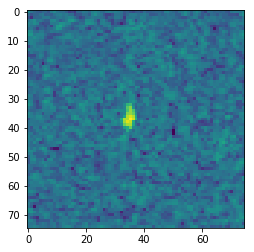

In [13]:
plt.imshow(img1[:,:,1])

Get rgb of image using color composite function

Thanks to **MadScientist** for **color composite**.
Here is the kernal -- 
https://www.kaggle.com/keremt/getting-color-composites

In [14]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
#         r = ((band_1 - np.mean(band_1)) / (np.max(band_1) - np.min(band_1))) 
#         g = ((band_2 - np.mean(band_2)) / (np.max(band_2) - np.min(band_2))) 
#         b = ((band_3 - np.mean(band_3)) / (np.max(band_3) - np.min(band_3)))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [15]:
# Trained with data about rgb
rgb_train = color_composite(train)
rgb_train.shape

(1604, 75, 75, 3)

In [16]:
# Test with data about rgb
rgb_test = color_composite(test)
rgb_test.shape

(8424, 75, 75, 3)

### Exploring images before training CNN model

Looking at random ships


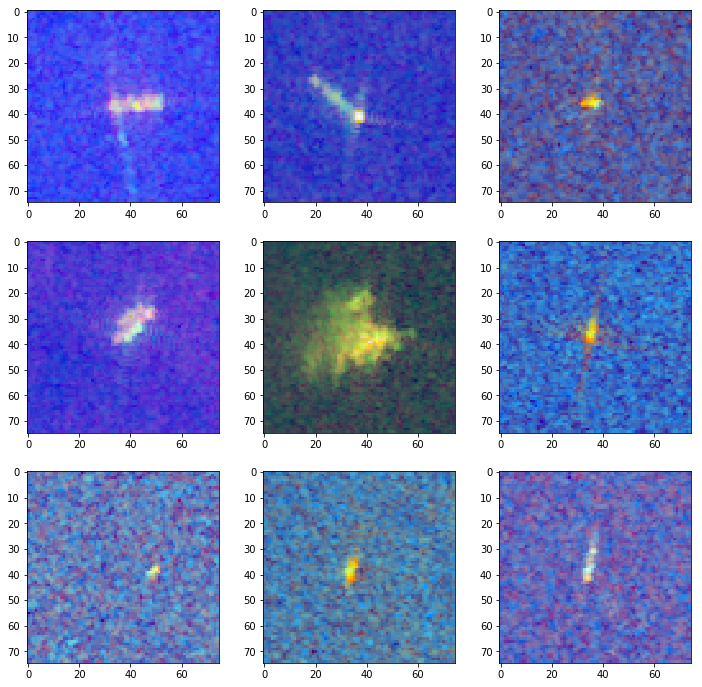

In [17]:
# look at random ships
print('Looking at random ships')
ships = np.random.choice(np.where(train.is_iceberg ==0)[0], 9)
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[ships[i], :, :]
    ax.imshow(arr)
    
plt.show()

Looking at random icebergs


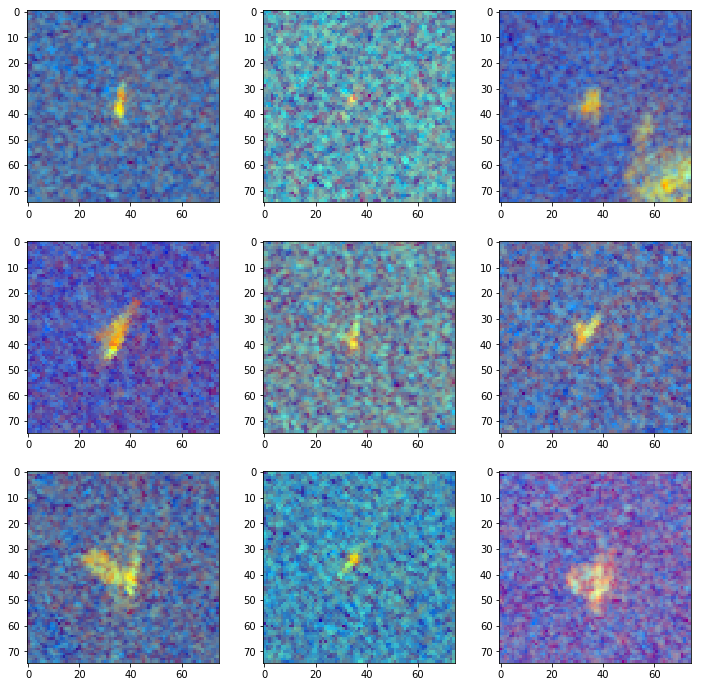

In [18]:
# look at random iceberges
print('Looking at random icebergs')
ice = np.random.choice(np.where(train.is_iceberg ==1)[0], 9)
fig = plt.figure(200,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[ice[i], :, :]
    ax.imshow(arr)
    
plt.show()

### Observation from images --

• Ships have a trace of bright lights around them which will be taken as a feature in CNN  
• Ships are more consistent with shapes  
• Icebergs shape vary more than ships


saving images in directories (train, valid, test)

In [ ]:
# # making directories for training resnet (as it need files to be in right dir)

os.makedirs(f'{path}composites', exist_ok= True)
os.makedirs(f'{path}composites/train', exist_ok=True)
os.makedirs(f'{path}composites/valid', exist_ok=True)
os.makedirs(f'{path}composites/test', exist_ok=True)

dir_list = [f'{path}composites/train', f'{path}composites/valid']

for i in dir_list:
    os.makedirs(f'{i}/ship')
    os.makedirs(f'{i}/iceberg')

The reason of converting these images to .png is that the **pretrained ConvLearner** that I am going to call takes image as input

In [19]:
! ls {path}composites

models	test  tmp  train  valid


In [ ]:
# split
train_y, valid_y = train_test_split(train.is_iceberg, test_size=0.10)

train_iceberg_index, train_ship_index, valid_iceberg_index, valid_ship_index  = train_y[train_y==1].index, train_y[train_y==0].index, valid_y[valid_y==1].index, valid_y[valid_y==0].index


#save train images
for idx in train_iceberg_index:
    img = rgb_train[idx]
    plt.imsave(f'{path}/composites/train/iceberg/' + str(idx) + '.png',  img)

for idx in train_ship_index:
    img = rgb_train[idx]
    plt.imsave(f'{path}/composites/train/ship/' + str(idx) + '.png',  img)    
    
#save valid images
for idx in valid_iceberg_index:
    img = rgb_train[idx]
    plt.imsave(f'{path}/composites/valid/iceberg/' + str(idx) + '.png',  img)

for idx in valid_ship_index:
    img = rgb_train[idx]
    plt.imsave(f'{path}/composites/valid/ship/' + str(idx) + '.png',  img)

#save test images
for idx in range(len(test)):
    img = rgb_test[idx]
    plt.imsave(f'{path}/composites/test/' + str(idx) + '.png',  img)

let's check directory where files are saved. Ok we have **train, test and valid** directories

### I can start from here from next time

let's train first `resnet` model using fastai

In [20]:
path2 = 'data/processed/composites/'

let's look at a random ships now (from png) to make sure images are saved in directory

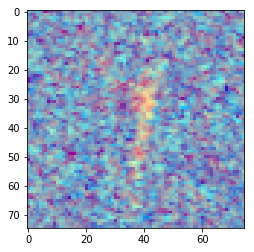

In [21]:
files = !ls {path2}valid/ship | head

img = plt.imread(f'{path2}valid/ship/{files[0]}')
plt.imshow(img)

In [22]:
! ls {path2}

models	test  tmp  train  valid


#### Finding learning rate using lr finder  

One of the most sensitive hyperparameter for deep learning is **learning rate**. Finding a good learning rate is most important step to make a good model (without over or underfitting)

In [23]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.00)
    data = ImageClassifierData.from_paths(path2, test_name = 'test', bs = bs,
                                          tfms = tfms)
    return data 

In [24]:
arch=resnet34
sz = 75  # because our image size is 75*75
bs = 16 # because default batch size of 64 was not giving good converging loss

In [25]:
data = get_data(sz, bs)

In [26]:
data = data.resize(int(sz*1.5), 'tmp')

A Jupyter Widget

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=False) 

In [28]:
lrf = learn.lr_find()

A Jupyter Widget

 83%|████████▎ | 84/101 [00:14<00:02,  5.78it/s, loss=5.24] 

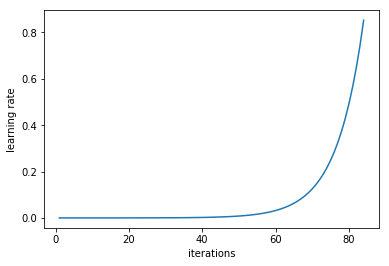

In [29]:
learn.sched.plot_lr()

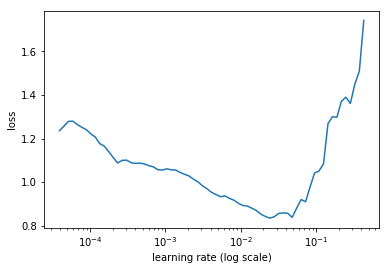

In [30]:
learn.sched.plot() 

Now, this plot is important to decide a good learning rate. We will not decide the learning rate at the lowest loss, which might sound confusing. But the catch is that we are going to do **differential annealing** to activate our layers which take varying learning rates. And the rate we chose here is going to be the maximum rate. So, we will chose some rate just before it bottoms up where loss is still falling.

Minimum is at 10^-2, I would chose **10^-3** is LR

### Stochastic descent with restart

In [31]:
lr = 0.001
learn.unfreeze()
learn.bn_freeze(False)

epochs = 3  
cycle length = 1  
cycle multiple = 2

In [32]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) # precompute was false # first fit

A Jupyter Widget


  2%|▏         | 2/101 [00:00<00:38,  2.59it/s, loss=0.85] 

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError:

[ 0.       0.66589  0.51449  0.74603]                        
[ 1.       0.58833  0.37483  0.82193]                        
[ 2.       0.45918  0.40679  0.77505]                        
[ 3.       0.47124  0.43996  0.77058]                        
[ 4.       0.46117  0.43787  0.75223]                        
[ 5.       0.40253  0.45217  0.74777]                        
[ 6.       0.36377  0.40525  0.79464]                        



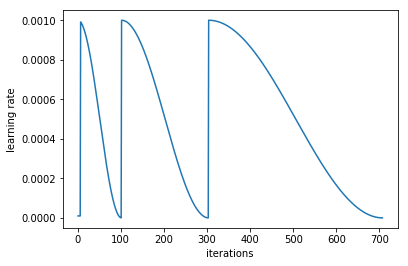

In [33]:
# stochastic descent with restart
learn.sched.plot_lr()

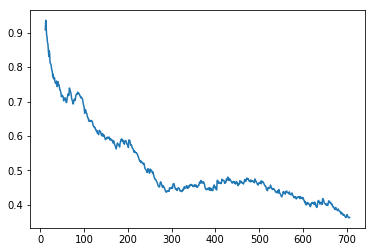

In [34]:
learn.sched.plot_loss()

In [36]:
learn.fit(lr,4, cycle_len=1, cycle_mult=2) # precompute was false # first fit

A Jupyter Widget

[ 0.       0.40167  0.3505   0.84821]                        
[ 1.       0.52901  0.59786  0.67634]                        
[ 2.       0.53447  0.67316  0.64509]                        
[ 3.       0.4827   0.55448  0.72991]                        
[ 4.       0.46647  0.5045   0.7433 ]                        
[ 5.       0.41846  0.50986  0.75223]                        
[ 6.       0.40515  0.54466  0.73438]                        
[ 7.       0.43873  0.54824  0.71429]                        
[ 8.       0.45788  0.41306  0.79688]                        
[ 9.       0.39355  0.42786  0.79911]                        
[ 10.        0.36757   0.31718   0.86161]                    
[ 11.        0.34645   0.33925   0.84152]                    
[ 12.        0.33664   0.35016   0.83705]                    
[ 13.        0.3603    0.38425   0.8192 ]                    
[ 14.        0.35384   0.32745   0.85045]                    



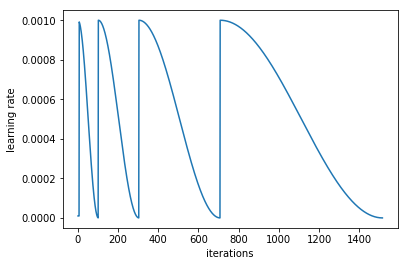

In [37]:
# stochastic descent with restart
learn.sched.plot_lr()

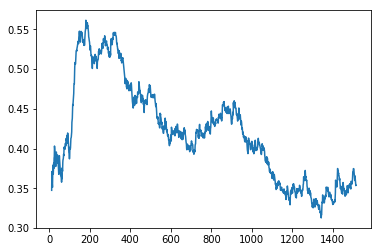

In [38]:
learn.sched.plot_loss()

Loss is decreasing with increaseing iterations

### Fine tuning and differential annealing

Since, the images that we have do not have very clear and sharp features which might be present in top layers of our pre-trained neural network. Let's **unfreeze** our layers and calculate activations

In [40]:
lr = 0.01

In [41]:
lrs=np.array([lr/9,lr/3,lr]) # use lr/100 and lr/10 respectively if images would have been larger in sizes

In [ ]:
%time learn.fit(lrs, 5, cycle_len=1, cycle_mult=2, cycle_save_name='resnet50')

A Jupyter Widget

[ 0.       0.37036  0.32537  0.86384]                        
[ 1.       0.48482  0.38466  0.83482]                        
[ 2.       0.42973  0.32886  0.86607]                        
[ 7.       0.85614  0.72995  0.69469]                        
[ 8.       0.84154  3.61304  0.57713]                        
[ 9.       0.69815  0.74343  0.66295]                        
[ 10.        0.60314   0.60006   0.72545]                    
[ 11.        0.48469   0.696     0.67411]                    
[ 12.        0.50549   0.76232   0.64062]                    
[ 13.        0.45606   0.64604   0.65179]                    
[ 14.        0.46706   0.7138    0.66741]                    
[ 15.        0.63976   0.63263   0.67411]                    
[ 17.        0.59012   0.53497   0.70536]                    
[ 18.        0.49364   0.59539   0.7433 ]                    
[ 19.        0.53277   0.6415    0.6942 ]                    
[ 20.        0.48624   0.64922   0.66518]                    
[ 21.   

In [ ]:
learn.sched.plot_loss()

In [ ]:
%time learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_loss()

###  Do Train It again (atleast 2 times)

In [ ]:
# to check validation accuray
log_preds,y = learn.TTA()
accuracy(log_preds,y)

In [ ]:
%time learn.fit(lrs,5 , cycle_len=1, cycle_mult=2)

TTA (Test Time Augmentation) simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them 

### Predictions

In [ ]:
# from here we know that 'icebergs' is label 0 and 'ships' is label 1.
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.TTA(is_test=True) # If need TTA
#log_preds = learn.predict(is_test=True) # if don't need TTA
log_preds

In [ ]:
probs_submit1 = np.exp(log_preds[0][:,0]) 
probs_submit1[:]

In [ ]:
# getting ids from test list
id_raw = data.test_dl.dataset.fnames
id_raw[1]


# using regex to take numbers from ids
id_pro = result_array = np.empty((0, len(id_raw)))
for i in range(len(id_raw)):
    stuff = int(re.findall(r'\d+', id_raw[i])[0])
    #print(type(str(stuff)))
    id_pro = np.append(id_pro,int(stuff))



In [ ]:
id_pro_list = []
for i in id_pro:
    id_pro_list.append(int(i))
id_pro_list[:4]

In [ ]:
# joining id and probability
d = {'index': id_pro_list, 'is_iceberg': probs_submit1}
submit1_df = pd.DataFrame(data=d)

In [ ]:
id_ = test['id']
id_pd = pd.DataFrame({'id': id_} )
submit1_df_sorted = submit1_df.sort_values('index')
submit1_df_sorted2 = pd.concat([id_, submit1_df_sorted.set_index('index')], axis = 1)
submit1_df_sorted2.dtypes
submit1_df.dtypes


In [ ]:
d['is_iceberg1']

In [ ]:
l=[]
for i in range(len(d['is_iceberg1'])):
    l.append(d['is_iceberg1'][i][0])

In [ ]:
len(l)

In [ ]:
d_new = {'index': id_pro_list, 'is_iceberg': l}
d_new['is_iceberg']

In [ ]:
submit1_df = pd.DataFrame(data=d_new)

In [ ]:
id_ = test['id']
id_pd = pd.DataFrame({'id': id_} )

In [ ]:
submit1_df_sorted = submit1_df.sort_values('index')
submit1_df_sorted2 = pd.concat([id_, submit1_df_sorted.set_index('index')], axis = 1)

In [ ]:
submit1_df_sorted2.dtypes

In [ ]:
submit1_df.dtypes

In [ ]:
#submit1_df.id = submit1_df.id.astype(str)

In [ ]:
submit1_df_sorted2.to_csv('data/processed/resnet50.csv', index = False)

In [ ]:
! head -5 data/processed/resnet50.csv

In [ ]:
submit_check = pd.read_csv("data/processed/resnet50.csv")

In [ ]:
submit_check.dtypes

In [ ]:
submit_check[:10]

In [ ]:
submit_check['is_iceberg']

`scp` submit1 to local machine to upload on kaggle

## Post analysis
Looking at correctly, incorrectly classified images


#### Analyzing results: looking at pictures  

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
* A few correct labels at random
* A few incorrect labels at random
* The most correct labels of each class (ie those with highest probability that are correct)
* The most incorrect labels of each class (ie those with highest probability that are incorrect)
* The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
log_pred1 = learn.TTA() # If need TTA

preds = np.argmax(log_pred1[0], axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_pred1[0][:,1])        # pr(ship)

#probs = submit_check['is_iceberg']
#submit_check['C'] = np.where(submit_check['is_iceberg'] >= 0.5,1, 0)
#preds = np.array(submit_check['C'])



In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(path2+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct icebergs")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct ships")

# SENet34

In [ ]:
!pwd

In [ ]:
!ls

In [ ]:
from fastai.models.cifar10.senet import SENet34

In [ ]:
bm = BasicModel(SENet34().cuda(),name='iceberg_34x34')

In [ ]:
arch = resnet34
sz = 75  # because our image size is 75*75
bs = 16 # because default batch size of 64 was not giving good converging loss

In [ ]:
data=get_data(32,bs)

In [ ]:
learn = ConvLearner(data,bm)